<html>
    <summary></summary>
         <div> <p></p> </div>
         <div style="font-size: 20px; width: 800px;"> 
              <h1>
               <left>Modeling Biological Processes - Chemical Master Equations</left>
              </h1>
              <p><left>============================================================================</left> </p>
<pre>Course: BIOM 480A5, Spring 2025
Instructor: Brian Munsky
Authors: Dr. Michael May, Brian Munsky
Contact Info: munsky@colostate.edu
</pre>
         </div>
    </p>

</html>

<details>
  <summary>Copyright info</summary>

```
Copyright 2024 Brian Munsky

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```
<details>



----------
# Learning Objectives for this Notebook:
--------------

After completing this notebook, you should be able to:
* Define the Chemical Master Equation and its components.
* Define, and be able to construct the state space for a CME analysis.
* Build a CME Infinitesimal Generator matrix using knowledge of stoichiometry vectors and propensity functions.
* Recognise import properties of the Infinitesimal Generator.
* Set up and solve the CME using Finite State Projections (FSP).
* Make plots and animations of CME solutions.

# 1. Motivation for Computing Single-Cell distributions
![alt text](Figures/ChemicalMasterEquation_2022/Slide2.png)
![alt text](Figures/ChemicalMasterEquation_2022/Slide3.png)

# 2. The Markov Chain Representation for Chemical Kinetics
![alt text](Figures/ChemicalMasterEquation_2022/Slide6.png)
![alt text](Figures/ChemicalMasterEquation_2022/Slide7.png)
![alt text](Figures/ChemicalMasterEquation_2022/Slide8.png)

# 3. The Chemical Master Equation

![alt text](Figures/ChemicalMasterEquation_2022/Slide9.png)
![alt text](Figures/ChemicalMasterEquation_2022/Slide11.png)


# 4. The Infitesimal Generator Matrix
![alt text](Figures/ChemicalMasterEquation_2022/Slide13.png)
![alt text](Figures/ChemicalMasterEquation_2022/Slide15.png)
![alt text](Figures/ChemicalMasterEquation_2022/Slide16.png)

# 5. The Finite State Projection Approximation
![alt text](Figures/ChemicalMasterEquation_2022/Slide17.png)
![alt text](Figures/ChemicalMasterEquation_2022/Slide18.png)
![alt text](Figures/ChemicalMasterEquation_2022/Slide19.png)
![alt text](Figures/ChemicalMasterEquation_2022/Slide20.png)
![alt text](Figures/ChemicalMasterEquation_2022/Slide21.png)
![alt text](Figures/ChemicalMasterEquation_2022/Slide22.png)

# 6. Python Codes
## 6.1. Import Libraries
```python

In [ ]:
# Load necessary packages and libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
from IPython.display import Image
import matplotlib.animation as animation
from matplotlib import rc
from scipy.integrate import ode

rc('animation', html='jshtml')
figSize=600

## 6.2. Construct the Infinitesimal Generator

Assuming that one has a defined model (in terms of stoichiometry matrix and propensit functions), then the main new concept needed to solve the CME using the FSP approach is to generate athe infitesimal generator matrix.  Below is a simple code to achieve this task.

In [ ]:
# Here, I provide a function to build the infinitesimal generator matrix for a continuous time Markov chain.
# The function takes the stoichiometry matrix S, the propensity vector function W, the states in the FSP approximation, and the time t as input.
# The function returns the infinitesimal generator matrix.

def build_inf_gen(S, W, states, pars, t=0):
    """ Build the infinitesimal generator matrix for a continuous time Markov chain.
    S: Stoichiometry matrix
    W: Propensity vector function
    states: list of states in FSP approximation
    t: time
    """
    
    # Determie the number of species, states and reactions
    nSpecies, nStates = states.shape
    nReactions = S.shape[1]
    
    # Compute the propensity functions for all states.
    propensities = W(states, t, pars)

    # Step through each reaction
    infGens = []
    infGen = np.zeros((nStates+1,nStates+1))
    sink = np.zeros(nStates)
    for mu in range(nReactions):
        # Compute flow of probability out of all states due to reaction mu
        infGens.append(-np.diag(propensities[mu,:]))
        
        for i in range(nStates):
            # Compute the states after the reaction mu
            newState = (states[:,i] + S[:,mu]).reshape(-1,1) 

            # Check if the state is non-negative
            if np.all(newState >= 0):
                # Find the index of the state
                try:
                    j = np.where((states == newState).all(axis=0))[0][0]
                    infGens[mu][j,i] += propensities[mu,i]

                except:
                    sink[i] += propensities[mu,i]
        # Add the current reaction to the infinitesimal generator
        infGen[:nStates,:nStates] += infGens[mu]
    
    # Add the sink as the final row of the infinitesimal generator
    infGen[nStates,:nStates] = sink

    return infGens, sink, infGen

# 7 Examples
## 7.1. Bursting Gene Expression

![alt text](Figures/StoichiometryAndPropensity_2023/Slide29.png)

### (Steps 1-4) Define Stoichiomety Matrix And Propensity Functions

In [ ]:
# Note - This code is copied exactly from the previous Module M5A.  We are going to use the same steps as
# before to define the model.  The only difference is that we are going to use the Gillespie algorithm to
# simulate the model instead of the ODE solver.

# Step 1: The number of species is 3:  'OFF', 'ON', 'Protein'
#         The initial conditions are:  x0 = [1, 0, 0]
#         The initial condition corresponds to 1 molecule of 'OFF' and 0 molecules of 'ON' and 'Protein'
#         The initial condition is defined as a 3 x 1 numpy array:
x0 = np.array([1, 0, 0])

# Step 2: The number of reactions is 4:
#         R1:  OFF -> ON
#         R2:  ON -> OFF
#         R3:  ON -> ON + Protein
#         R4:  Protein -> null

# Step 3: The stoichiometry matrix is a 3 x 4 matrix:
#         Rows correspond to species and columns correspond to reactions.
#         The matrix is defined as follows:
S = np.array([[-1, 1, 0, 0],
        [1, -1, 0, 0],
        [0, 0, 1, -1]])

# Step 4: Define the reaction rate parameters as a dictionary
pars = {'kon': 0.02, 'koff': 0.05, 'kP': 10, 'gam': 0.1}
def W(x,t,pars=pars):
  return np.array([pars['kon']*x[0],
                   pars['koff']*x[1],
                   pars['kP']*x[1],
                   pars['gam']*x[2]])


### Step 5 - Specify State Space

In [ ]:
# Specify the State Space of the FSP projection.
maxProtein = 180
states = np.zeros((3, maxProtein*2+2))
for i in range(maxProtein+1):
    states[:,2*i:2*i+2] = [[1,0], [0,1], [i,i]]

### Step 6 - Build Infinitesimal Generator Matrix.

In [ ]:
# Compute the Infinitesimal generators:
infGens, sink, infGenTotal = build_inf_gen(S, W, states, pars)

In [ ]:
#Show that probability is conserved by checking the column sum of the infinitesimal generator is zero.

# Perform the column sum of 'infGenTotal'
print('Maximum absolute column sum of the Infinitesimal Generator Matrix: ',
       np.max(np.abs(np.sum(infGenTotal, axis=0))))

### Step 7 - Specify the Initial Probability Distribution

In [ ]:
# Here is a convenient code to find which index corresponds to the initial state:

# Find which state corresponds to the initial condition
idx0 = np.where([(states[:,i]==x0).all() for i in range(states.shape[1])])

# Initialize the initial probability vector
P0 = np.zeros(infGenTotal.shape[1])

# Set the probability of the initial state to 1
P0[idx0] = 1


### Step 8 - Solve the FSP

In [ ]:
# Define the time span for the simulation
tspan = np.linspace(0, 2000, 100)

def FSPrhs(t, P):
    return infGenTotal @ P

def jac(t, P):
    return infGenTotal

In [ ]:
# Define the ODE solver
solver = ode(FSPrhs, jac=jac)
solver.set_integrator('vode', method='bdf')
solver.set_initial_value(P0)

# Solve the ODE
P_approach1 = np.zeros((len(tspan), len(P0)))
P_approach1[0,:] = P0
for i in range(1, len(tspan)):
    P_approach1[i,:] = solver.integrate(tspan[i])


In [ ]:
# Plot the results
plt.figure(figsize=(4,4))
plt.plot(tspan, P_approach1[:,-1])

plt.figure(figsize=(4,4))
pProtein = P_approach1[:,:-1:2]+P_approach1[:,1:-1:2]
plt.plot(pProtein[-1,:])

Solve again using the matrix exponential approach.
The solution of $P(x,t+\Delta t)$ is given by

$P(x,t+\Delta t)=EXPM(A\Delta t)\cdot P(t)$

In [ ]:
deltaT = tspan[1]-tspan[0]
expmAt = scipy.linalg.expm(infGenTotal*deltaT)

# Solve the ODE
P_approach2 = np.zeros((len(tspan), len(P0)))
P_approach2[0,:] = P0
for i in range(1, len(tspan)):
    P_approach2[i,:] = expmAt @ P_approach2[i-1,:]


In [ ]:
# Plot the results
plt.figure(figsize=(4,4))
plt.plot(tspan, P_approach1[:,-1])
plt.plot(tspan, P_approach2[:,-1],'--')
# labels
plt.xlabel('Time')
plt.ylabel('Escape Probability')
plt.legend(['ODE Solver', 'Matrix Exponential'])

plt.figure(figsize=(4,4))
pProtein1 = P_approach1[:,:-1:2]+P_approach1[:,1:-1:2]
pProtein2 = P_approach2[:,:-1:2]+P_approach2[:,1:-1:2]
plt.plot(pProtein[-1,:])
plt.plot(pProtein1[-1,:],'--')
plt.xlabel('Protein Level')
plt.ylabel('Probability')
plt.legend(['ODE Solver', 'Matrix Exponential'])

**Compare the FSP Solution to the SSA solution.**

In [ ]:
# Here is our Gillespie algorithm from Module M5B (slightly simplified)

def gillespie(x0, t0, tmax, S, pars, trajectoryTimes = None):
    # If the user did not provide specific time points, we will use the default
    if trajectoryTimes is None:
        trajectoryTimes = np.linspace(t0, tmax, 20)
    
    # Initialize the time and the state
    t = t0
    x = x0
     
    # Initialize the output
    states = np.zeros((len(trajectoryTimes), len(x0)))

    # next time index
    nextTimeIndex = 0

    # Run the simulation
    while t < tmax:

        Wx = W(x, t, pars)
        Wx_sum = np.sum(Wx)

        # Compute the time of the next reaction
        t += -np.log(np.random.rand()) / Wx_sum

        # Check to see if we need to save the state
        while t >= trajectoryTimes[nextTimeIndex]:
            states[nextTimeIndex] = x
            nextTimeIndex += 1
            if nextTimeIndex >= len(trajectoryTimes):
                return states
        
        # Find the index of the next reaction
        r = np.random.rand()
        i = 0
        W_sum = Wx[0]
        while W_sum / Wx_sum < r:
            i += 1
            W_sum += Wx[i]

        # Update the state
        x = x + S[:, i]

def nGillespies(x0, t0, tmax, S, pars, nTrajectories, trajectoryTimes = None):
    if trajectoryTimes is None:
        trajectoryTimes = np.linspace(t0, tmax, 20)
    
    # Initialize the output
    states = np.zeros((nTrajectories, len(trajectoryTimes), len(x0)))

    # Run the simulation
    for i in range(nTrajectories):
        states[i,:,:] = gillespie(x0, t0, tmax, S, pars, trajectoryTimes)
    
    return states

In [ ]:
# Run the Gillespie algorithm
nTrajectories = 100
SSAsolns = nGillespies(x0, 0, np.max(tspan), S, pars, nTrajectories, tspan)

In [ ]:
# Plot a histogram of the results at the final time.

proteinCounts = SSAsolns[:,-1,2]
plt.hist(proteinCounts, bins=range(0, maxProtein+1), density=True)
plt.plot(pProtein[-1,:], alpha=0.5)

plt.xlabel('Protein Level')
plt.ylabel('Probability')
plt.legend(['FSP', 'Gillespie'])

***Explore the eigenvalues and eigenvectors of the Infinitesimal Generator Matrix.***

For any CME model, there will be at least one eigenvalue equal to zero, and the rest will have negative real parts, meaning that they will decay to zero over time.  The zero-eigenvalue corresponds to the steady state distribution (can you see why?).  Hint -- remember that for any eigenvalue, v, for matrix A, we have $A
\cdot v = \lambda*v$.

In [ ]:
# Replace the absrbing sink with a reflecting boundary.
infGenReflect = infGenTotal.copy()
infGenReflect = infGenReflect[:-1,:-1]
infGenReflect = infGenReflect - np.diag(np.sum(infGenReflect, axis=0))

# Compute the eigenvalues and eigenvectors of the new infinitesimal generator
eigenvalues, eigenvectors = np.linalg.eig(infGenReflect)

# Plot the real and imaginary parts of the eigenvalues
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(np.real(eigenvalues), np.imag(eigenvalues), 'o')
ax[0].set_xlabel('Real')
ax[0].set_ylabel('Imaginary')

# Find the eigenvector corresponding to the zero eigenvalue
idx = np.argsort(eigenvalues)

# Extract the eigenvector corresponding to the second smallest eigenvalue, and plot it
evecSmallest =eigenvectors[:,idx[-1]]

# Normalize the eigenvector
evecSmallest = evecSmallest / np.sum(evecSmallest)
P_2ndEigVec = evecSmallest[::2]+evecSmallest[1::2]

# Plot the eigenvector
ax[1].plot(pProtein[-1,:])
ax[1].plot(P_2ndEigVec,'--')
ax[1].set_xlabel('Protein Level')
ax[1].set_ylabel('Probability')
ax[1].legend(['ODE Solver', 'Second Eigenvector'])


## 7.2. Example: Genetic Toggle Switch
![alt text](Figures/StoichiometryAndPropensity_2023/Slide32a.png)

In [ ]:
# In this example, we will analyze the genetic toggle switch model using the FSP.
# The parameters and rates for this model are copied from the previous modules.

# Step 1: The number of species is 2: 'LacI', 'LambdaCI'
#         The initial conditions are:  x0 = [10, 40]
#         The initial condition corresponds to 10 molecules of 'LacI' and 100 of 'LambdaCI'
#         The initial condition is defined as a 2 x 1 numpy array:
x0 = np.array([30, 40])

# Step 2: The number of reactions is 4:
#         R1:  null -> LacI
#         R2:  null -> LambdaCI
#         R3:  LacI -> null
#         R4:  LambdaCI -> null

# Step 3: The stoichiometry matrix is a 2 x 4 matrix:
#         Rows correspond to species and columns correspond to reactions.
#         The matrix is defined as follows:
S = np.array([[1, 0, -1, 0],
        [0, 1, 0, -1]])

# Step 4: Define the reaction rate parameters as a dictionary
pars = {'k11': 0.02, 'k12': 1, 'a1': 10, 'eta1': 2, 'gamma1':0.02,
        'k21': 0.02, 'k22': 1, 'a2': 10, 'eta2': 2, 'gamma2':0.02}
def W(x,t,pars=pars):
  return np.array([ pars['k11'] + pars['k12']/(1+(x[1]/pars['a1'])**pars['eta1']),
                    pars['k21'] + pars['k22']/(1+(x[0]/pars['a2'])**pars['eta2']),
                    pars['gamma1']*x[0],
                    pars['gamma2']*x[1]])          

In [ ]:
# Step 5 - Specify the State Space of the FSP projection.
maxLacI = 80
maxLambdaCI = 80
states = np.zeros((2,(maxLacI+1)*(maxLambdaCI+1)), dtype=int)
for i in range(maxLacI+1):
    for j in range(maxLambdaCI+1):
        states[:,i*(maxLambdaCI+1) + j] = [i, j]

states = states[:,np.sum(states, axis=0) <= 120]

In [ ]:
# Step 6 - Compute the Infinitesimal generators:
infGens, sink, infGenTotal = build_inf_gen(S, W, states, pars)


In [ ]:
# Step 7 - Define the initial probability vector

# Find which state corresponds to the initial condition
idx0 = np.where([(states[:,i]==x0).all() for i in range(states.shape[1])])
# Initialize the initial probability vector
P0 = np.zeros(infGenTotal.shape[1])
# Set the probability of the initial state to 1
P0[idx0] = 1

In [ ]:
# Step 8 - Use Exponential Matrix to solve the FSP
tspan = np.linspace(0, 500, 100)

deltaT = tspan[1]-tspan[0]
expmAt = scipy.linalg.expm(infGenTotal*deltaT)

In [ ]:
# Solve the ODE
Ptoggle = np.zeros((len(tspan), len(P0)))
Ptoggle[0,:] = P0
for i in range(1, len(tspan)):
    Ptoggle[i,:] = expmAt @ Ptoggle[i-1,:]

jointDist = np.zeros((len(tspan), maxLacI+1, maxLambdaCI+1))
for i in range(len(states[0])):
    jointDist[:, states[0,i], states[1,i]] = Ptoggle[:,i]

In [ ]:
# Make an animation of the results
fig, ax = plt.subplots(1,3, figsize=(12,4))
def frame(iFrame):        
    # ax.clear()
    ax[0].cla()
    ax[1].cla()
    ax[2].cla()

    # Next, plot the final distributions
    distLacI = np.sum(jointDist[iFrame,:], axis=(1))
    distLamdaCI= np.sum(jointDist[iFrame,:], axis=(0))
    distBoth = jointDist[iFrame,:]

    ax[0].plot(np.arange(maxLacI+1), distLacI)
    ax[0].set_xlabel('Lacl')
    ax[0].set_ylabel('Probability')
    ylim = ax[0].get_ylim()

    ax[1].plot(np.arange(maxLambdaCI+1), distLamdaCI)
    ax[1].set_xlabel('RNA')
    ax[1].set_ylim(ylim)

    ax[2].contourf(np.arange(maxLambdaCI+1), np.arange(maxLacI+1), distBoth)
    ax[2].set_xlabel('Lacl')
    ax[2].set_ylabel('LambdaCI')
    ax[2].set_ylim([0, 60])
    ax[2].set_xlim([0, 60])
    return ax
anim = animation.FuncAnimation(fig, frame, frames=len(tspan), blit=False, repeat=False)
anim

## 7.3. Example: Bursting Gene Expression with mRNA and Protein

Here we extend the above analysis to include both transcription and translation in the gene expression process.

We will consider a negative autoregulation model, where the protein deactivates its own gene expression.

In [ ]:
# Step 1: The number of species is 3:  'OFF', 'ON', 'mRNA', 'Protein'
#         The initial conditions are:  x0 = [1, 0, 0, 0]
#         The initial condition corresponds to 1 molecule of 'OFF' and 0 molecules of 'ON', 'mRNA' and 'Protein'
#         The initial condition is defined as a 4 x 1 numpy array:
x0 = np.array([1, 0, 5, 5])

# Step 2: The number of reactions is 7:
#         R1:  OFF -> ON
#         R2:  ON + 2 x Protein -> OFF
#         R3:  ON -> ON + mRNA
#         R4:  OFF -> OFF + mRNA
#         R5:  mRNA -> null
#         R6:  mRNA -> mRNA + Protein
#         R7:  Protein -> null

# Step 3: The stoichiometry matrix is a 3 x 4 matrix:
#         Rows correspond to species and columns correspond to reactions.
#         The matrix is defined as follows:
S = np.array([[-1, 1, 0, 0, 0, 0, 0],
              [1, -1, 0, 0, 0, 0, 0],
              [0, 0, 1, 1, -1, 0, 0],
              [2, -2, 0, 0, 0, 1, -1]])

# Step 4: Define the reaction rate parameters as a dictionary
pars = {'kon': 0.01, 'koff': 0.01, 'krOn': 2, 'krOff':0.1, 'kP':0.03, 'gamR':0.1, 'gamP':0.01}
def W(x,t,pars=pars):
  return np.array([pars['kon']*x[0],
                   pars['koff']*x[1]*x[3]*(x[3]-1)/2,
                   pars['krOn']*x[1],
                   pars['krOff']*x[0],
                   pars['gamR']*x[2],
                   pars['kP']*x[2],
                   pars['gamP']*x[3]])


In [ ]:
# Step 5: Specify the State Space of the FSP projection.
maxR = 30
maxP = 60
states = np.zeros((4, (maxR+1)*(maxP+1)*2),int)
for i in range(maxR+1):
    for j in range(maxP+1):
        states[:,2*(i*(maxP+1)+j):2*(i*(maxP+1)+j)+2] = \
            [[1,0], [0,1], [i,i], [j,j]]
        
print(states.shape)

In [ ]:
# Step 6: Compute the Infinitesimal generators:
infGens, sink, infGenTotal = build_inf_gen(S, W, states, pars)

In [ ]:
# Step 7 - Define the initial probability vector

# Find which state corresponds to the initial condition
idx0 = np.where([(states[:,i]==x0).all() for i in range(states.shape[1])])
# Initialize the initial probability vector
P0 = np.zeros(infGenTotal.shape[1])
# Set the probability of the initial state to 1
P0[idx0] = 1

In [ ]:
# Step 8: Solve for the matrix exponential and use it to find the CME solution
tspan = np.linspace(0, 1000, 100)
deltaT = tspan[1]-tspan[0]
expmAt = scipy.linalg.expm(infGenTotal*deltaT)

In [ ]:
P_burstRnaProtein = np.zeros((len(tspan), len(infGenTotal)))
P_burstRnaProtein[0,:] = P0
for i in range(1, len(tspan)):
    P_burstRnaProtein[i,:] = expmAt @ P_burstRnaProtein[i-1,:]

In [ ]:
# Plot the results - First, plot the error term to see how good is the solution approximation.
plt.figure(figsize=(4,4))
plt.plot(tspan, P_burstRnaProtein[:,-1])

# Next plot the average mRNA level versus time
plt.figure(figsize=(4,4))
meanProtein = P_burstRnaProtein[:,:-1] @ states[2,:]
plt.plot(tspan, meanProtein)

# Next plot the average protein level versus time
plt.figure(figsize=(4,4))
meanProtein = P_burstRnaProtein[:,:-1] @ states[3,:]
plt.plot(tspan, meanProtein)


In [ ]:
jointDist = np.zeros((len(tspan), 2, 2, maxR+1, maxP+1))
for i in range(len(states[0])):
    jointDist[:, states[0,i], states[1,i], states[2,i], states[3,i]] = P_burstRnaProtein[:,i]



In [ ]:
# Next, plot the final distributions
distOn = np.sum(jointDist[-1,:], axis=(0,2,3))
distProt = np.sum(jointDist[-1,:], axis=(0,1,2))
distRNA = np.sum(jointDist[-1,:], axis=(0,1,3))
distRNAprot = np.sum(jointDist[-1,:], axis=(0,1))

fig, ax = plt.subplots(1,4, figsize=(16,4))
ax[0].bar(np.arange(2), distOn)
ax[0].set_xlabel('ON')
ax[0].set_ylabel('Probability')

ax[1].plot(np.arange(maxR+1), distRNA)
ax[1].set_xlabel('RNA')

ax[2].plot(np.arange(maxP+1), distProt)
ax[2].set_xlabel('Protein')

ax[3].contourf(np.arange(maxP+1), np.arange(maxR+1), distRNAprot)
ax[3].set_xlabel('Protein')
ax[3].set_ylabel('RNA')

In [ ]:
# Make an Animation of the joint mRNA/Protein probability distribution over time.
fig, ax = plt.subplots(1,4, figsize=(16,4))
def frame(iFrame):
    # ax.clear()
    ax[0].cla()
    ax[1].cla()
    ax[2].cla()
    ax[3].cla()

    # Next, plot the final distributions
    distOn = np.sum(jointDist[iFrame,:], axis=(0,2,3))
    distProt = np.sum(jointDist[iFrame,:], axis=(0,1,2))
    distRNA = np.sum(jointDist[iFrame,:], axis=(0,1,3))
    distRNAprot = np.sum(jointDist[iFrame,:], axis=(0,1))

    ax[0].bar(np.arange(2), distOn)
    ax[0].set_xlabel('ON')
    ax[0].set_ylabel('Probability')

    ax[1].plot(np.arange(maxR+1), distRNA)
    ax[1].set_xlabel('RNA')

    ax[2].plot(np.arange(maxP+1), distProt)
    ax[2].set_xlabel('Protein')

    ax[3].contourf(np.arange(maxP+1), np.arange(maxR+1), distRNAprot)
    ax[3].set_xlim([0,30])
    ax[3].set_ylim([0,20])
    ax[3].set_xlabel('Protein')
    ax[3].set_ylabel('RNA')
    return ax
anim = animation.FuncAnimation(fig, frame, frames=len(tspan), blit=False, repeat=False)
anim

In [ ]:
# Note, that distributions can hide some very interesting phenomena. 
# To see how that might be the case, let's look at some SSA simulations of the same process.

ssaTrajectories = nGillespies(x0, 0, np.max(tspan), S, pars, 20, tspan)
# Make an Animation of the joint mRNA/Protein probability distribution over time.
fig, ax = plt.subplots(1,1, figsize=(4,4))
def frame(iFrame):
    ax.clear()

    for i in range(20):
        ax.plot(ssaTrajectories[i,:iFrame,3], ssaTrajectories[i,:iFrame,2], 'k-', alpha=0.15)
        ax.plot(ssaTrajectories[i,iFrame,3], ssaTrajectories[i,iFrame,2], 'o')

    ax.set_xlabel('Protein')
    ax.set_ylabel('RNA')
    ax.set_xlim([0,30])
    ax.set_ylim([0,20])
    return ax
anim = animation.FuncAnimation(fig, frame, frames=len(tspan), blit=False, repeat=False)
anim


## 7.4. Example: Ecology Extinction-Explosion Model

A population of rabbits inhabit an island whose popluation over time follows a stochastic trajectory (SSA). If the population of rabbits ever hits zero or one by random chance, no rabbits can ever be made again and the population is destined to be zero forerver. Conversely, when the number of rabbits becomes large, the rate of birth exceeds the rate of death and the population is destined to explode to infinte rabbits. There are two destinies for the stochastic rabbit population: explosion or extinction.

1.  Create the Extinction-Explosion Model infinitesimal generator for an arbitrary number of states using the figure below. Let kappa=0.005 and gamma = 0.05 using the figure below.
2.  Solve for the time dynamics of the system using the matrix exponential.


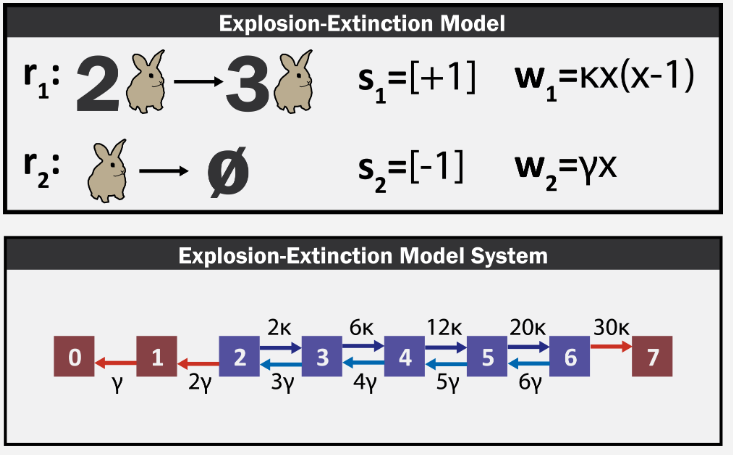

In [ ]:
# Step 1: The number of species is 1:  'Rabbit'
#         The initial conditions are:  x0 = [10] 

# Step 2: The number of reactions is 2:
#         R1:  Rabbit + Rabbit -> Rabbit + Rabbit + Rabbot
#         R2:  Rabbit -> null
# The reaction rate parameters as a dictionary are:
pars = {'kappa': 0.005, 'gamma': 0.05}

# Step 3: The stoichiometry matrix is a 1 x 2 matrix:
S = np.array([1, -1]).reshape(1,2)

# Step 4: Define the propensity function
def W(x,t,pars=pars):
    return np.array([pars['kappa']*x[0]*(x[0]-1), pars['gamma']*x[0]])

# Step 5: Define the State Space of the FSP projection.
maxRabbit = 100
states = np.zeros((1, maxRabbit+1))
states[0,:] = np.arange(maxRabbit+1)

# Step 6: Compute the Infinitesimal generators:
infGens, sink, infGenTotal = build_inf_gen(S, W, states, pars)

In [ ]:
# Step 7: Define the time span, and solve for the distribution as a function of time.
tspan = np.linspace(0, 200, 100)

# Define the initial distribution
x0 = [10]
P0 = np.zeros(len(infGenTotal))
P0[x0[0]] = 1

# Solve the ODE using the EXPM Approach
expAt = scipy.linalg.expm(infGenTotal*(tspan[1]-tspan[0]))
P = np.zeros((len(tspan), len(P0)))
P[0,:] = P0
for i in range(1, len(tspan)):
    P[i,:] = expAt @ P[i-1,:]

# Plot the results
plt.figure(figsize=(4,4))
plt.plot(tspan, P[:,-1])
plt.plot(tspan, P[:,0])
plt.xlabel('Time')
plt.ylabel('Escape Probability')
plt.legend(['Explosion', 'Extinction'])

In [ ]:
# Make an Animation of the probability distribution over time.
fig = plt.figure(figsize=(6,4))
ax = plt.axes()
def frame(iFrame):
    ax.clear()
    plt.title("P(x;t)")
    ax.set_xlabel('Number of Rabbits')
    ax.set_ylabel('Probability')
    ax.step(range(maxRabbit+2),P[iFrame,:])
    return ax
anim = animation.FuncAnimation(fig, frame, frames=len(tspan), blit=False, repeat=False)
anim

# 8. Using Linear Algebra to Compute CME Dynamics

Recall that the CME is given by
$$\frac{d\mathbf{P}}{dt} = \mathbf{AP}$$

where $\mathbf{P}$ is the **probability mass vector**, and $\mathbf{A}$ is the **infinitesimal generator matrix**.  The solution to this equation is given by
$$\mathbf{P}(t) = \text{expm}\left({\mathbf{A}t}\right)\mathbf{P}(0),$$

where $\text{expm}$ is the matrix exponential function.  The matrix exponential is defined as
$$\text{expm}(\mathbf{A}) = \sum_{n=0}^{\infty} \frac{\mathbf{A}^n}{n!},$$

where $\mathbf{A}^n$ is the matrix $\mathbf{A}$ raised to the $n$th power, and $n!$ is the factorial of $n$.  The matrix exponential can be computed using the Taylor series expansion, or using numerical methods such as the Padé approximation or the scaling and squaring method.

## 8.1. Steady State Distribution

The **steady state distribution** is the solution to the CME when the system has reached equilibrium.  This means that the probability mass vector does not change over time, i.e., 

$$\lim_{t\rightarrow \infty}\frac{d\mathbf{P}}{dt} = \mathbf{0}.$$

This means that the steady state dictribution $\mathbf{P}_{ss}$ is an eigenvector of the infinitesimal generator matrix $\mathbf{A}$ with an eigenvalue of zero, i.e.,
$$\lim_{t\rightarrow \infty}\frac{d\mathbf{P}}{dt} =\mathbf{A}\mathbf{P}_{ss} = \lambda_{ss}\mathbf{P}_{ss} = 0\mathbf{P}_{ss},$$
where $\lambda_{ss} = 0$.  

## 8.2. Eigenvalues and Eigenvectors of the Infinitesimal Generator Matrix
We can also examine and use other eigenvalue/vector pairs from the infinitesimal generator matrix. Let the matrix $\mathbf{V} = [\mathbf{v}_1,\mathbf{v}_2,\ldots,\mathbf{v}_N]$ be the matrix of eigenvectors of the infinitesimal generator matrix $\mathbf{A}$, and let the diagonal matrix $\mathbf{\Lambda}$ be the matrix of eigenvalues of the infinitesimal generator matrix $\mathbf{A}$. Note - one can compute all eigenvalues and eigenvectors of the infinitesimal generator matrix using the `numpy.linalg.eig` function in Python. 

## 8.3. Projecting the CME Solution onto its Eigenvector Space

The CME solution can be transformed into the eigenvector space of the infinitesimal generator matrix.  To transform the probability mass vector $\mathbf{P}$ onto the eigenvector space, we multiply the probability mass vector by the inverse of the eigenvector matrix, i.e.,
$$\mathbf{P}_{eigen} = \mathbf{V}^{-1}\mathbf{P}.$$

We can do this same transformation to both sides of the CME equation, i.e.,
$$\mathbf{V}^{-1}\frac{d\mathbf{P}}{dt} = \mathbf{V}^{-1}\mathbf{A}\mathbf{P},$$
which (by substituting $\mathbf{P} = \mathbf{V}\mathbf{P}_{eigen}$) gives us
$$\frac{d\mathbf{P}_{eigen}}{dt} = \mathbf{V}^{-1}\mathbf{A}\mathbf{V}\mathbf{P}_{eigen},$$
which can be simplified to
$$\frac{d\mathbf{P}_{eigen}}{dt} = \mathbf{\Lambda}\mathbf{P}_{eigen},$$
where $\mathbf{\Lambda}$ is the diagonal matrix of eigenvalues of the infinitesimal generator matrix $\mathbf{A}$.

## 8.4. Solving the CME in Eigenvector Space
The solution to the CME in eigenvector space is given by
$$\mathbf{P}_{eigen}(t) = \text{expm}\left({\mathbf{\Lambda}t}\right)\mathbf{P}_{eigen}(0),$$
where $\text{expm}$ is the matrix exponential function.  The matrix exponential of a diagonal matrix is simply the diagonal matrix with each element raised to the power of the corresponding eigenvalue, i.e.,
$$\text{expm}\left({\mathbf{\Lambda}t}\right) = \text{diag}\left(e^{\lambda_1 t}, e^{\lambda_2 t}, \ldots, e^{\lambda_N t}\right),$$
where $\lambda_i$ is the $i^{th}$ eigenvalue of the infinitesimal generator matrix $\mathbf{A}$.

All eigenvalues of the infinitesimal generator matrix have non-positive real parts.  This means that all eigenvalues will decay to zero over time, except for the zero eigenvalues, which will remain constant.  In particular, if there is only one zero eigenvalue, then the steady state distribution will be the only non-decaying component of the CME solution.  If there are multiple zero eigenvalues, then the steady state distribution will be a linear combination of the corresponding eigenvectors.

## 8.5. Example: Using Eigenvalue and Eigenvector Analysis on the CME.

In [ ]:
## Let's  look again at the infinitesimal generator matrix for the Rabbit model above.

# Compute the eigenvalues and eigenvectors of the infinitesimal generator
eigenvalues, eigenvectors = np.linalg.eig(infGenTotal)

# Plot the real and imaginary parts of the eigenvalues
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(np.real(eigenvalues), np.imag(eigenvalues), 'o')
ax.set_xlabel('Real')
ax.set_ylabel('Imaginary')
plt.show()

# Print the number of eigenvalues equal to zero
print('Number of eigenvalues equal to zero: ', np.sum(np.abs(eigenvalues) < 1e-10))

In this case, there are two eigenvalues equal to zero, and the steady state distribution will be a linear combination of the corresponding eigenvectors. 

These two eigenvectors correspond to the two possible outcomes -- explosion or extinction.  The steady state distribution will be a linear combination of these two eigenvectors, which means that the system will have a non-zero probability of either outcome.  Let's see how to compute the final probabilities of explosion and extinction using the eigenvalue and eigenvector analysis.

In [ ]:
# Project the initial condition onto the eigenvectors.
# We will do this by solving the linear system of equations:
# P0 = eigenvectors @ P0_eigen
P0_eigen = np.linalg.solve(eigenvectors, P0)

# Find the indices of the eigenvalues that are close to zero
idx = np.argsort(eigenvalues)
# Extract the two valeus of P0_eigen that correspond to the two eigenvalues that are close to zero
P_Explosion =  np.real(P0_eigen[idx[-1]])
P_Extinction = np.real(P0_eigen[idx[-2]])

print('P_Explosion: ', P_Explosion)
print('P_Extinction: ', P_Extinction)

# Add dashed lines to previous plot to compare approaches.
plt.figure(figsize=(4,4))
plt.plot(tspan, P[:,-1],'b')
plt.plot(tspan, P[:,0],'r')
# add horizontal lines
plt.axhline(y=P_Explosion, color='r', linestyle='--')
plt.axhline(y=P_Extinction, color='b', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Escape Probability')
plt.legend(['Explosion - Full CME Solution', 'Extinction - Full CME Solution ', 'Explosion - SS Solution', 'Extinction - SS Solution'])
plt.show()